In [1300]:
import numpy as np
import json
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from matplotlib.path import Path
import data_handling as dh
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D, Dropout, Input
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as K
import os

from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import regularizers


In [1554]:

class DataGenerator(Iterator):
    """
    Given a NumPy array of images,
    generate batches images and rotation angles.
    """

    def __init__(self, images,angles, input_shape=None, batch_size=64,
                  shuffle=False, seed=None,n_angles=360):

        self.images = images
        self.angles= angles
        self.input_shape = input_shape
        self.batch_size = batch_size
 
        self.shuffle = shuffle
        self.n_angles = n_angles
 
        N=self.images.shape[0]

        super(DataGenerator, self).__init__(N, batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        # create array to hold the images
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros((len(index_array),2), dtype='float32')
        # iterate through the current batch
        for i, j in enumerate(index_array):
            image = self.images[j]
            angle = self.angles[j]
#            if self.rotate:
#                 # get a random angle
#                rotation_angle = np.random.randint(360)
#            else:
#                rotation_angle = 0

#             # generate the rotated image
#            rotated_image = generate_rotated_image(
#                 image,
#                 rotation_angle,
#                 size=self.input_shape[:2],
#                 crop_center=self.crop_center,
#                 crop_largest_rect=self.crop_largest_rect
#             )

            # add dimension to account for the channels if the image is greyscale
  #          if rotated_image.ndim == 2:
   #             rotated_image = np.expand_dims(rotated_image, axis=2)

            # store the image and label in their corresponding batches
            batch_x[i] = image
            batch_y[i] = angle
            # convert the numerical labels to binary labels
        #batch_y = to_categorical(batch_y, self.n_angles)

        # preprocess input images
#        if self.preprocess_func:
 #           batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)
    
def angle_difference(x, y):
    """
    Calculate minimum difference between two angles.
    """
    return 180 - abs(abs(x - y) - 180)


def angle_error(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a binary vector.
    """
    diff = angle_difference(K.argmax(y_true), K.argmax(y_pred))
    return K.mean(K.cast(K.abs(diff), K.floatx()))


def vector_angle_difference(y_true,y_pred):
    """ calculate mean angle difference between two vectors"""
    a_t=tf.math.atan2(y_true[:,0],y_true[:,1]) / 0.017453292519943295
    a_p=tf.math.atan2(y_pred[:,0],y_pred[:,1]) / 0.017453292519943295
    diff=angle_difference(a_t,a_p)
    return K.mean(K.cast(K.abs(diff), K.floatx()))

In [1753]:
def crop_image_centre(image, box_size):
    """crop the central square from an image, eg if rotated"""
    width, height = image.size
    left = (width-box_size)/2
    top = (height - box_size)/2
    right = (width+box_size)/2
    bottom = (height+box_size)/2
    return image.crop((left,top,right, bottom))
    
def generate_n_examples(image_file_name,angles_image,mask, target_box_size, number_of_examples,rotate=True,precision=1):
    """generate matched pairs of tissue and labelled angle
    can choose to rotate to vertical. 
    In this case box size will be used to calculate crop size prior to rotation and recropping"""
    if rotate:
        box_size=np.ceil(np.sqrt(2*target_box_size**2)).astype(int)
    else:
        box_size=target_box_size
    im=Image.open(image_file_name).convert('L')
    w,h=im.size
    images=[]
    angles=[]
    while len(images) < number_of_examples:
        y=np.random.randint(0,h-box_size)
        x=np.random.randint(0,w-box_size)
        
        #mask check
        if np.mean(mask[y:y+box_size,x:x+box_size])<0.6:
            pass
        else:
            bounding_box=[x,y,x+box_size,y+box_size]
            imc = dh.generate_tissue_box(im,bounding_box)
            angle= dh.calculate_box_angle(angles_image, bounding_box)
            images.append(imc)
            angles.append(angle)
    if rotate:
        rotated_images=np.zeros((number_of_examples,target_box_size,target_box_size,1))
        rotation_angles=np.random.randint(0,360, number_of_examples)
        for k, rotation_angle in enumerate(rotation_angles):
            rotated = images[k].rotate(rotation_angle)
            cropped=crop_image_centre(rotated,target_box_size)
            rotated_images[k]=np.array(cropped).reshape(target_box_size,target_box_size,1)
            
        images=rotated_images
        angles=(angles-rotation_angles)%360
    orig_images=np.zeros((number_of_examples,target_box_size,target_box_size,1))
    for k,image in enumerate(images):
        orig_images[k]=np.array(image).reshape(target_box_size,target_box_size,1)
    return orig_images/255.0, np.array(angles)

import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def rotate_triangle(origin, triangle, angle):
    """rotate 3 points around specified origin"""
    angle=2*math.pi*angle/360
    return (rotate(origin, triangle[0],angle),rotate(origin, triangle[1],angle),rotate(origin, triangle[2],angle))

def translate_triangle(triangle, box_size):
    """translate triangle from centre by random amount """
    translation_vector=np.random.uniform(0,box_size,2)
    triangle = triangle+translation_vector
    return triangle


    
    
def simulated_images(target_box_size, number_of_examples, rotate_range=360,noise=False,precision=1, 
                     n_triangles=1,jitter=3):
    """create triangular image of speicifed size and rotate + add some speckled noise
    n_triangles - number of triangles to plot
    jitter = degree of jitter of triangle rotations
    noise - random noise
    precision - return angles binned to specified precision eg 0-35 for precision 10"""
    
    box_size=np.ceil(np.sqrt(2*target_box_size**2)).astype(int)
    base_images=[]
    for example in range(number_of_examples):
        im=Image.new('L',(box_size,box_size),0)
        if n_triangles==1:
        #triangle pyramidal neuron
            box_size=np.random.randint(40,80)
            #print(box_size)
            #box_size=80
            triangle=((box_size/2,box_size/4),(3*box_size/5,2*box_size/3),(2*box_size/5,2*box_size/3,))
            box_size=80
            triangle= np.round(translate_triangle(triangle, box_size/2)).astype(int)
            intensity=np.random.randint(140,255)

            ImageDraw.Draw(im).polygon(tuple(map(tuple,triangle)),  fill=intensity, outline =intensity)
            base_images.append(im)


        else:

            #define centre to rotate about
            com=(box_size/2,box_size/2)
            for t in range(n_triangles):
                #set triangle size. Could be scaled as a variable
                size=np.random.randint(75,80)
#                size=80
                jitter_angle=np.random.randint(0,jitter)
                intensity=np.random.randint(140,255)

                triangle=((size/2,size/4),(3*size/5,2*size/3),(2*size/5,2*size/3,))
                com=np.mean(triangle,axis=0)

                #add 90 as initial triangle is pointing sideways
                new_r=rotate_triangle(com, triangle, jitter_angle)
                new_t= np.round(translate_triangle(new_r, box_size/2)).astype(int)

                ImageDraw.Draw(im).polygon(tuple(map(tuple,new_t)),  fill=intensity, outline =intensity)
            base_images.append(im)

    images=np.zeros((number_of_examples,target_box_size,target_box_size,1))
    if rotate_range:
        angles=np.random.randint(0,rotate_range, number_of_examples)
    else:
        angles=np.zeros(number_of_examples)
    for k,angle in enumerate(angles):
        rotated=base_images[k].rotate(360-angle)
        image=crop_image_centre(rotated,target_box_size)
        image=np.array(image).reshape(target_box_size,target_box_size,1)
        if noise:
            image=image+np.abs(np.random.randn(100, 100,1))*noise
            image[image>255]=255
        images[k]=image
        
    return images/255, bin_angles(angles,precision)

def simulated_images_tmp(target_box_size, number_of_examples, rotate_range=360,noise=False,precision=1, 
                     n_triangles=1,jitter=3):
    """create triangular image of speicifed size and rotate + add some speckled noise
    n_triangles - number of triangles to plot
    jitter = degree of jitter of triangle rotations
    noise - random noise
    precision - return angles binned to specified precision eg 0-35 for precision 10"""
    
    box_size=np.ceil(np.sqrt(2*target_box_size**2)).astype(int)
    base_images=[]
    for example in range(number_of_examples):
        im=Image.new('L',(box_size,box_size),0)
        for t in range(n_triangles):
            
#        if n_triangles==1:
        #triangle pyramidal neuron
            box_size=np.random.randint(30,80)
            #print(box_size)
            #box_size=80
            triangle=((box_size/2,box_size/4),(3*box_size/5,2*box_size/3),(2*box_size/5,2*box_size/3,))
            box_size=80
            new_r=rotate_triangle(com, triangle, jitter_angle)
            triangle= np.round(translate_triangle(triangle, box_size/2)).astype(int)
            new_r=rotate_triangle(com, triangle, jitter_angle)
            intensity=np.random.randint(140,255)

            ImageDraw.Draw(im).polygon(tuple(map(tuple,triangle)),  fill=intensity, outline =intensity)
        base_images.append(im)
        

#         else:

#             #define centre to rotate about
#             com=(box_size/2,box_size/2)
#             for t in range(n_triangles):
#                 #set triangle size. Could be scaled as a variable
#                 size=np.random.randint(75,80)
# #                size=80
#                 jitter_angle=np.random.randint(0,jitter)
#                 intensity=np.random.randint(140,255)

#                 triangle=((size/2,size/4),(3*size/5,2*size/3),(2*size/5,2*size/3,))
#                 com=np.mean(triangle,axis=0)

#                 #add 90 as initial triangle is pointing sideways
#                 new_r=rotate_triangle(com, triangle, jitter_angle)
#                 new_t= np.round(translate_triangle(new_r, box_size/2)).astype(int)

#                 ImageDraw.Draw(im).polygon(tuple(map(tuple,new_t)),  fill=intensity, outline =intensity)
#             base_images.append(im)

    images=np.zeros((number_of_examples,target_box_size,target_box_size,1))
    if rotate_range:
        angles=np.random.randint(0,rotate_range, number_of_examples)
    else:
        angles=np.zeros(number_of_examples)
    for k,angle in enumerate(angles):
        rotated=base_images[k].rotate(360-angle)
        image=crop_image_centre(rotated,target_box_size)
        image=np.array(image).reshape(target_box_size,target_box_size,1)
        if noise:
            image=image+np.abs(np.random.randn(100, 100,1))*noise
            image[image>255]=255
        images[k]=image
        
    return images/255, bin_angles(angles,precision)



def bin_angles(angles,precision):
    """bin labelled angles to degree of specified accuracy"""
    binned=np.round(angles/precision).astype(int)*precision
    #set max to zero
    binned[binned==360]=0
    return binned

In [1764]:
#desired precision, is used to round recorded angles, not actual angles
precision=1
n_angles=np.round(360/precision).astype(int)
training_images,train_angles=simulated_images_tmp(100,1000,noise=140,precision=precision,n_triangles=5,jitter=3)
val_images,val_angles=simulated_images_tmp(100,300,noise=140,precision=precision,n_triangles=5,jitter=3)
test_images,test_angles=simulated_images_tmp(100,100,noise=140,precision=precision,n_triangles=5,jitter=3)


213


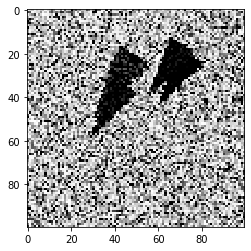

In [1774]:
#val_images,val_angles=simulated_images(100,300,noise=140,precision=precision,n_triangles=1,jitter=0)

k=np.random.randint(100)
plt.imshow(val_images[k,:,:,0],cmap='Greys')
print(val_angles[k])

In [1488]:
#desired precision, is used to round recorded angles, not actual angles
precision=1
n_angles=np.round(360/precision).astype(int)
drawn_columns, cortex = dh.load_json_annotations('cortex.json')
mask = dh.mask_image('cortex.png',cortex)
angles_image, angles_mask=dh.columns_to_angles_image(drawn_columns,mask)
angles_image=dh.dilate_values_inside_cortex(angles_image,angles_mask,mask)
training_images,train_angles=generate_n_examples('cortex.png',angles_image,mask, 100, 10000,rotate=True,precision=precision)
val_images,val_angles=generate_n_examples('cortex.png',angles_image,mask, 100, 300,rotate=False,precision=precision)
test_images,test_angles=generate_n_examples('cortex.png',angles_image,mask, 100, 100,rotate=False,precision=precision)

# plt.imshow(training_images[0,:,:,0])
# print(train_angles[0])

/data1/bigbrain/column_orientation/data_handling.py:24: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


KeyboardInterrupt: 

In [1213]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True


In [1580]:
#print(np.rad2deg(math.atan2(train_y[0,1],train_y[0,0])),90-train_angles[0])


-49.00000000000001 -49


In [1579]:
#train_angles[0]

139

In [1775]:
#regression model
train_angles_r=np.deg2rad(train_angles)
val_angles_r=np.deg2rad(val_angles)
test_angles_r=np.deg2rad(test_angles)
train_y=np.array((np.sin(train_angles_r),np.cos(train_angles_r))).T
val_y=np.array((np.sin(val_angles_r),np.cos(val_angles_r))).T
test_y=np.array((np.sin(test_angles_r),np.cos(test_angles_r))).T

input_shape = (100, 100, 1)
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
# number of classes
nb_classes = 2

input = Input(shape=(input_shape))
x = Conv2D(nb_filters, kernel_size, activation='relu')(input)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = Conv2D(nb_filters, kernel_size, activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x) #,kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x) #,kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.25)(x)
x = Dense(nb_classes, activation='linear')(x)
model = Model(inputs=input, outputs=x)

# model compilation
model.compile(loss='mean_squared_error',
              optimizer='adam',
             metrics=[vector_angle_difference])

In [1776]:
model.summary()

Model: "model_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_408 (Conv2D)          (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_409 (Conv2D)          (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_204 (MaxPoolin (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_410 (Conv2D)          (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_411 (Conv2D)          (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_205 (MaxPoolin (None, 22, 22, 32)        0  

In [1777]:
# training parameters
batch_size = 64
nb_epoch = 200
model_name = 'histo_conv_regress'

output_folder = 'models'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# callbacks
monitor = 'val_loss'
checkpointer = ModelCheckpoint(
    filepath=os.path.join(output_folder, model_name + '.hdf5'),
    monitor=monitor,
    save_best_only=True
)

In [1778]:

reduce_lr = ReduceLROnPlateau(monitor=monitor, patience=20)
early_stopping = EarlyStopping(monitor=monitor, patience=20)
tensorboard = TensorBoard()



In [ ]:
model.fit_generator(
    DataGenerator(
        training_images,train_y,
        input_shape=input_shape,
        batch_size=batch_size,
        shuffle=True,
        n_angles=n_angles,
    ),
    steps_per_epoch=len(training_images) / batch_size,
    epochs=nb_epoch,
    validation_data=DataGenerator(
        val_images, val_y,
        input_shape=input_shape,
        batch_size=batch_size,
        n_angles=n_angles,
    ),
    validation_steps=len(val_images) / batch_size,
    callbacks=[checkpointer, reduce_lr, early_stopping, tensorboard],
    workers=10
)

Epoch 1/200
16/15 [==============================] - 23s 1s/step - loss: 0.4994 - vector_angle_difference: 87.7050 - val_loss: 0.5275 - val_vector_angle_difference: 86.1083
Epoch 2/200
16/15 [==============================] - 9s 556ms/step - loss: 0.4742 - vector_angle_difference: 75.7609 - val_loss: 0.3203 - val_vector_angle_difference: 33.0527
Epoch 3/200
16/15 [==============================] - 9s 557ms/step - loss: 0.3308 - vector_angle_difference: 44.9491 - val_loss: 0.1952 - val_vector_angle_difference: 24.7482
Epoch 4/200
16/15 [==============================] - 9s 557ms/step - loss: 0.2501 - vector_angle_difference: 32.6295 - val_loss: 0.1317 - val_vector_angle_difference: 21.3581
Epoch 5/200
16/15 [==============================] - 9s 556ms/step - loss: 0.2055 - vector_angle_difference: 28.9578 - val_loss: 0.1207 - val_vector_angle_difference: 19.9397
Epoch 6/200
16/15 [==============================] - 9s 556ms/step - loss: 0.1697 - vector_angle_difference: 25.1774 - val_loss

In [1684]:

y_pred = model.predict(test_images)

82


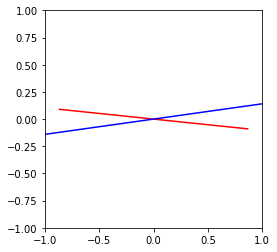

In [1708]:
k=np.random.randint(100)
plt.plot([-y_pred[k,0],y_pred[k,0]],[-y_pred[k,1],y_pred[k,1]],'r')
plt.plot([-test_y[k,0],test_y[k,0]],[-test_y[k,1],test_y[k,1]],'b')
plt.xlim(-1,1)
plt.ylim(-1,1)
print(test_angles[k])
plt.gca().set_aspect('equal', adjustable='box')


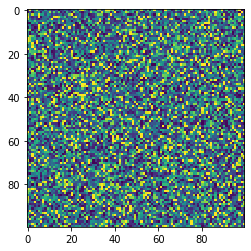

In [957]:
k=np.random.randint(100)

plt.imshow(val_images[k,:,:,0])

In [635]:
val_y

array([[0.15643447, 0.98768834],
       [0.06975647, 0.99756405],
       [0.2419219 , 0.97029573],
       [0.10452846, 0.9945219 ],
       [0.17364818, 0.98480775],
       [0.2923717 , 0.95630476],
       [0.17364818, 0.98480775],
       [0.1391731 , 0.99026807],
       [0.1391731 , 0.99026807],
       [0.2419219 , 0.97029573],
       [0.190809  , 0.98162718],
       [0.15643447, 0.98768834],
       [0.190809  , 0.98162718],
       [0.2419219 , 0.97029573],
       [0.08715574, 0.9961947 ],
       [0.05233596, 0.99862953],
       [0.0348995 , 0.99939083],
       [0.27563736, 0.9612617 ],
       [0.08715574, 0.9961947 ],
       [0.22495105, 0.97437006],
       [0.05233596, 0.99862953],
       [0.2419219 , 0.97029573],
       [0.05233596, 0.99862953],
       [0.15643447, 0.98768834],
       [0.1391731 , 0.99026807],
       [0.        , 1.        ],
       [0.25881905, 0.96592583],
       [0.01745241, 0.9998477 ],
       [0.0348995 , 0.99939083],
       [0.25881905, 0.96592583],
       [0.